# Google Colabで物体認識を簡単に試す

物体認識をpytorchで行う[MMDetection](https://github.com/open-mmlab/mmdetection)というライブラリが公開されています。今回、学習済みモデルを使ってこの物体認識をGoogle Colabで実行してみます。

まずはColabのランタイムのタイプをGPUに変更してください。
次にpipでライブラリをインストールします。ライブラリの名前はmmdetです。

In [1]:
!pip install mmdet

     |████████████████████████████████| 563kB 27.3MB/s 
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=264260 sha256=4f4dd3efdd92aaf4f949955ad912a1d141d4f00f1890740e376e49dd503aa498
  Stored in directory: /root/.cache/pip/wheels/a2/b0/8d/3307912785a42bc80f673946fac676d5c596eee537af7a599c
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=a259f3f1041ab5c3496360efd193e536be05f403f7fe81162d01387627ca566a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built mmpycocotools terminaltables


簡単にインストールできました。ライブラリをimportしましょう。

In [2]:
import mmdet

ModuleNotFoundError: ignored

駄目です。ライブラリの依存関係の設定に不備があるようです。というわけで、mmcvをインストールするのですが、実はmmcvでは上手くいきません。mmcv-fullが必要です。

mmcv-fullのインストールには時間がかかります。

In [4]:
%%time
!pip install mmcv-full

  Using cached https://files.pythonhosted.org/packages/25/bd/f47992449359ed0d403a84d5228195b8f12e7e99181e1e45acab6e966627/mmcv-full-1.3.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/6a/00/b08f23b7d7e1e14ce01419a467b583edbb93c6cdb8654e54a9cc579cd61f/addict-2.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/0d/8814e79eb865eab42d95023b58b650d01dec6f8ea87fc9260978b1bf2167/yapf-0.31.0-py2.py3-none-any.whl
  Created wheel for mmcv-full: filename=mmcv_full-1.3.1-cp37-cp37m-linux_x86_64.whl size=22542286 sha256=82a483af17411c275ede9b0cd4e76dd1d62d4448bbbf2b6b8d480f3dec3c8b8f
  Stored in directory: /root/.cache/pip/wheels/75/40/57/0825abf01599edf55ba2a23444af249e79205dc0572786418d
Successfully built mmcv-full
CPU times: user 2.66 s, sys: 290 ms, total: 2.95 s
Wall time: 10min 51s


それでは改めてmmdetをインポートします。

In [5]:
import mmdet

できました。

次に学習済みモデルを取得します。[MMDetection](https://github.com/open-mmlab/mmdetection)のページに様々なモデルが載っています。今回はfaster_rcnnを使いましょう。リンクを辿り、学習済みモデルのURLを調べて、wgetでファイルを取得します。

In [6]:
# Faster R-CNN
!wget -P /content https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2021-04-22 05:48:46--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.60.111
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.60.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/x-www-form-urlencoded]
Saving to: ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

faster_rcnn_r50_fpn 100%[===================>] 159.54M  16.4MB/s    in 11s     

2021-04-22 05:48:58 (14.4 MB/s) - ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



次に必要なモジュールをimportします。

In [19]:
from mmdet.apis.inference import init_detector, inference_detector, show_result_pyplot

importできました。しかしここで困った事態に。init_detector()の引数にはconfigファイルと重みファイルを指定します。重みファイルは先ほど取得しました。ではconfigファイルは？同様にURLを指定して取得しようとしましたが、configファイルは単一ファイルではなく、複数必要でした。結局、ソースをまるごと取得したほうが簡単ですので、取得しましょう。

In [17]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd /content/mmdetection

Cloning into 'mmdetection'...
remote: Enumerating objects: 17031, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 17031 (delta 90), reused 122 (delta 48), pack-reused 16808
Receiving objects: 100% (17031/17031), 20.43 MiB | 34.69 MiB/s, done.
Resolving deltas: 100% (11757/11757), done.
/content/mmdetection


ソースの中のconfigファイルと先に取得した重みファイルを指定してモデルを作成します。deviceには'cuda:0'を指定します。

In [18]:
model = init_detector('configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py', '/content/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth', device='cuda:0')

Use load_from_local loader


ソースの中の画像を利用して物体認識を実行し、結果を表示します。

/usr/local/lib/python3.7/dist-packages/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


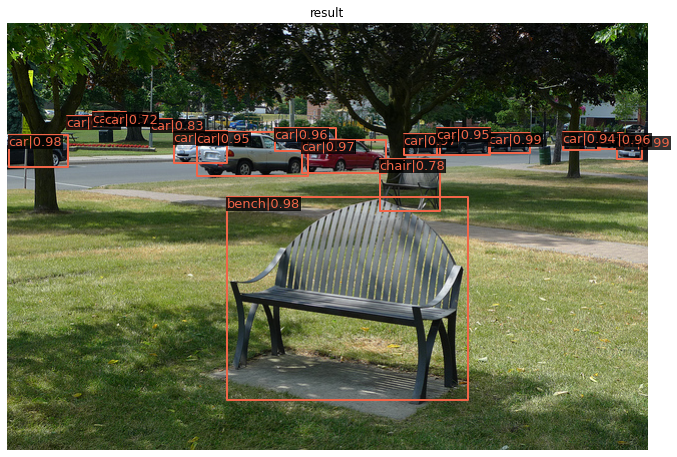

In [20]:
result = inference_detector(model, "demo/demo.jpg")
show_result_pyplot(model, "demo/demo.jpg", result, score_thr=0.7)

あっさり成功しました。でもWarningが出ていて格好悪いです。本来、警告に従って修正すべきですが、面倒なので上辺だけ取り繕います。

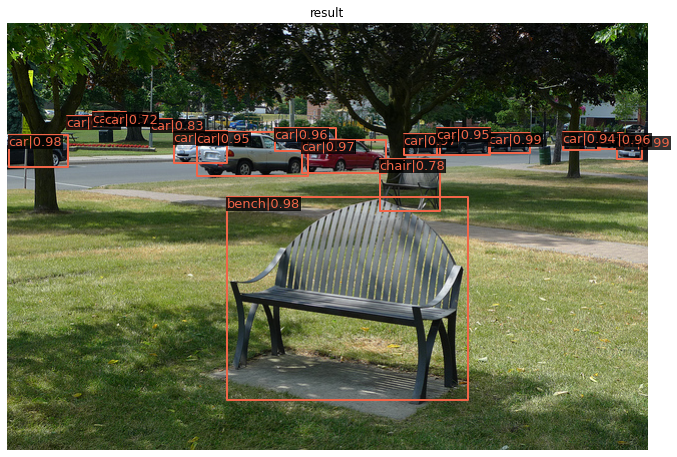

In [25]:
import warnings
warnings.simplefilter('ignore')
result = inference_detector(model, "demo/demo.jpg")
show_result_pyplot(model, "demo/demo.jpg", result, score_thr=0.7)

次にMask R-CNNを試しましょう。こちらは物体の位置だけでなく、その領域も認識してくれます。

まずは学習済みの重みファイルを取得します。

In [29]:
# Mask R-CNN
!wget -P /content http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth

--2021-04-22 06:22:12--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177862517 (170M) [application/octet-stream]
Saving to: ‘/content/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth’

mask_rcnn_r50_fpn_1 100%[===================>] 169.62M  9.07MB/s    in 19s     

2021-04-22 06:22:32 (8.95 MB/s) - ‘/content/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth’ saved [177862517/177862517]



次にモデルの作成と認識実行です。

Use load_from_local loader


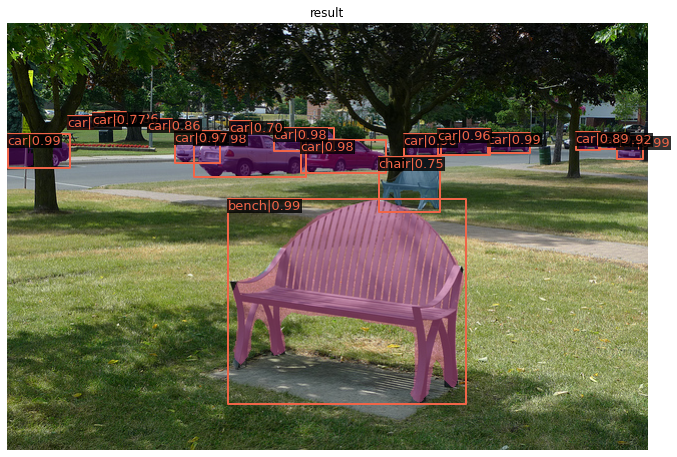

In [30]:
model = init_detector("configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py", "/content/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth", device="cuda:0")
result = inference_detector(model, "demo/demo.jpg")
show_result_pyplot(model, "demo/demo.jpg", result, score_thr=0.7)

驚くほど簡単に実行できました。

[MMDetection](https://github.com/open-mmlab/mmdetection)には他にもたくさんのモデルが公開されています。どれも今回の記事と同じ方法で実行できますので、試してみてはいかがでしょうか。
